In [1]:
%matplotlib inline
from tqdm import tqdm
import numpy as np
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.dist_math import binomln, betaln, bound
np.set_printoptions(suppress=True)

/Users/ded/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7201 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:86:00.0)
/Users/ded/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Helper function for visualization
import re
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [3]:
import pickle
with open('data/gch-5000-10-0.12-8.50.pkl', 'rb') as f:
  GCH, TH = pickle.load(f)

# Sample periods and observed workers
S = 10
rawdata = np.array(GCH, dtype = int)
V = len(GCH)

# make capture history data
data, freqs = np.unique(rawdata, axis = 0, return_counts = True)
H = len(freqs)

print('Sampling periods:', S)
print('Unique patterns:', H)
print('Unique workers:', V)

Sampling periods: 10
Unique patterns: 40
Unique workers: 207


In [4]:
# We want to see the survival marks to compute the total survival
# e.g, Arrive: 1, Depart: 2 => 011
# Dims: SxSxS
def make_survival(S):
    mask = np.zeros([S,S,S])  # arrival, departure, presence_sequence
    for s in np.arange(S):
        for q in np.arange(s,S):
            c1 = np.zeros(s)
            c2 = np.ones(q-s)
            c3 = np.zeros(S-q)
            mask[s,q]= np.concatenate((c1, c2, c3))
    return mask
survival = make_survival(S)
survival.shape

(10, 10, 10)

In [5]:
# A more compact way to represent all Arrival and departures from the data
# This is part of the input data, so we preprocess it!
def get_hmask(S, H, data):
    h_mask = np.zeros((H,S,S))
    for wh in np.arange(H):
        f, l = data[wh, 0] , data[wh, 1]
        h_mask[wh, :f+1, l:] = 1
    return h_mask
hmask = get_hmask(S, H, data)
hmask.shape

(40, 10, 10)

In [6]:
# For a given outcome in {1,S} (Frequency of capture that's not 0) 
# Generate the Binomial parameters n and i   choose(n, i)
# Nn is the duration from arrival to departure
# Ni is the Frequency we are intersted in
# Dim: SxSxS
def make_binmask(S, data):
    i = data[:,2]
    i = i[:, np.newaxis, np.newaxis] *  np.ones((H, S, S))
    n = np.broadcast_to(np.triu(np.ones([S,S]), 0).cumsum(axis =1), (H, S, S))
    return i, n
Ni, Nn = make_binmask(S, data)
print('Tensor with number of captures', Ni.shape)
print('Tensor with durations from first to last seen', Nn.shape)

Tensor with number of captures (40, 10, 10)
Tensor with durations from first to last seen (40, 10, 10)


In [7]:
# Helper functions for the Beta Bernoulli Process
# TODO: switch to a single function even for the special case of 0 captures.

def get_BetaBi(a,b, S, Ni, Nn):
    # The beta binomial
    BBi  =  bound(betaln(Ni + a, Nn - Ni + b) - betaln(a, b),
                     Ni >= 0, Ni <= Nn,
                     a > 0, b > 0)
    # The above is the computation of the log, so we take the exponent
    return tt.exp(BBi)

def get_BetaB0(a, b, S):
    # The beta binomial for 0 captures
    Nn = tt.triu(tt.ones([S,S]), 0).cumsum(axis =1).eval()
    #B0 = tt.gammaln(n + b) - tt.gammaln(n + a + b) + tt.gammaln(a + b) - tt.gammaln(b)
    B0 = bound(betaln(a, Nn + b) - betaln(a, b), 
               a > 0, b > 0)
    return tt.exp(B0)

In [8]:
def logp_capture(arrival_probs, departure_probs, a, b, U, survival_mask, Ni, Nn, S, V):
    def ll_capture_f(Nh, data_first_last_mask):
          
        # Likelihood of observing Li captures
        
        # compute the survival
        survival_prob = tt.pow(1 - departure_probs, survival_mask)
        survival_prob = tt.prod(survival_prob, axis=2)
        # compute the arrival and departure
        LAD      = arrival_probs[:, np.newaxis] * survival_prob * departure_probs    # SxS
        # keep only true possibilites
        True_LAD = LAD * data_first_last_mask # SxSxS
        
        # sum along the freqencies of catpures
        BetaBi  = get_BetaBi(a, b, S, Ni, Nn)
        Li      = tt.batched_tensordot(True_LAD, BetaBi, axes = 2) # S
        
        # Likelihood of No-Capture L0
        
        True_LAD0    = LAD * tt.triu(tt.ones((S,S)), 0)
        BetaB0   = get_BetaB0(a, b, S)
        L0       = tt.sum(True_LAD0 * BetaB0)
        
        # Multinomial
        obj1 = tt.gammaln(V + U + 1) - tt.gammaln(U + 1) - tt.sum(tt.gammaln(Nh+1))
        obj2 = tt.sum(Nh * tt.log(Li))
        obj3 = U * tt.log(L0)
        
        objective = obj1 + obj2 + obj3 
        
        return objective
    
    return ll_capture_f

In [10]:
# custom log-liklihood
# model
with pm.Model() as model:
    # parameters
    U = pm.Uniform('Unseen', lower=1000, upper=10000)
    a = pm.Uniform('alpha', .01, .3)
    b = pm.Uniform('beta', 1., 15.)
    
    phi = tt.zeros(S)
    phi_v    = pm.Uniform('departure', 0.1, .3, shape=S-1)
    phi = tt.set_subtensor(phi[S-1], 1.)
    phi = tt.set_subtensor(phi[:S-1],phi_v)
    
    arr    = pm.Dirichlet('arrival', a=np.array([1./S]*S), shape=S)
    #U_print = tt.printing.Print('Unseen')(U)
    #a_print = tt.printing.Print('alpha')(a)
    #b_print = tt.printing.Print('beta')(b)
    # Model Log-likelihood
    ob = pm.DensityDist('x', logp_capture(arr, phi, a, b, U, survival, Ni, Nn, S, V), 
                        observed={'Nh': freqs ,
                                  'data_first_last_mask': hmask})

In [15]:
with model:
  posterior = pm.sample(2000, chains = 2, cores = 1, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [arrival, departure, beta, alpha, Unseen]
100%|██████████| 3000/3000 [05:55<00:00,  8.44it/s]
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7206039953249994, but should be close to 0.8. Try to increase the number of tuning steps.
There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


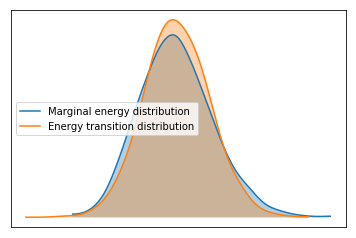

In [13]:
pm.energyplot(posterior);

IndexError: index 5 is out of bounds for axis 0 with size 5

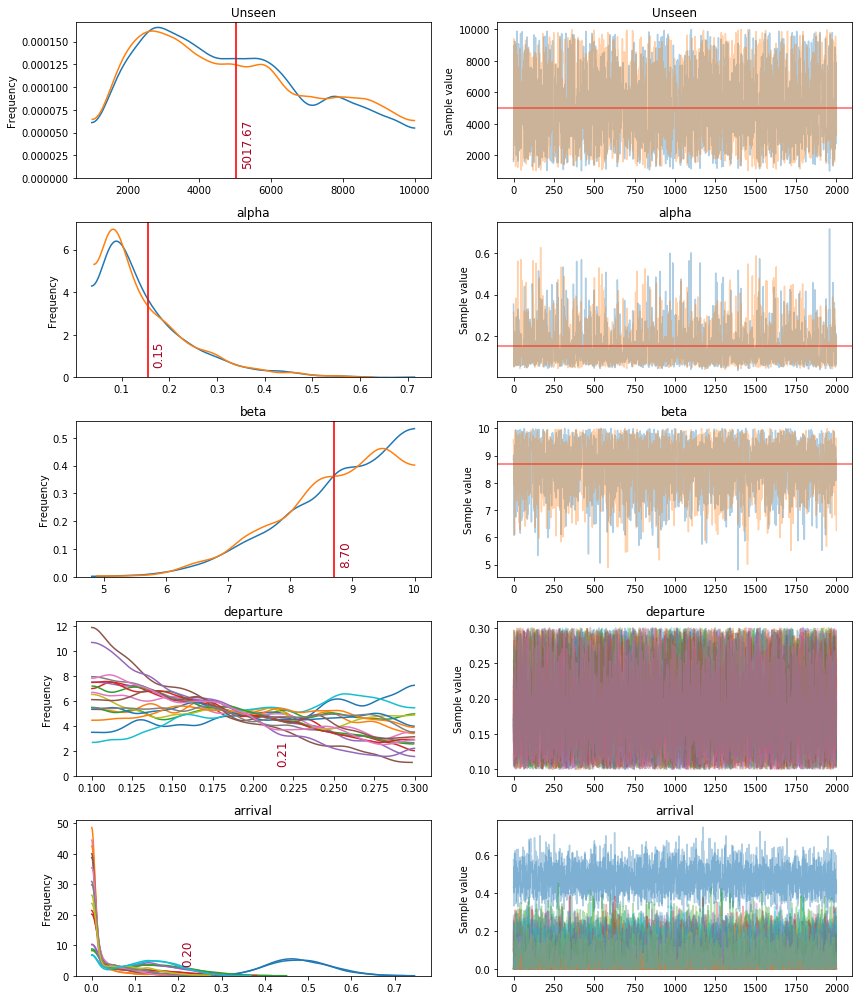

In [14]:
plot_traces(posterior);

In [16]:
pm.summary(posterior)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Unseen,9262.930727,3601.069747,156.847762,3.510032e+03,16213.430380
alpha,0.277294,0.139117,0.006339,9.757129e-02,0.558161
beta,5.184211,0.726297,0.031056,4.113269e+00,6.789172
departure__0,0.190696,0.052270,0.002046,1.014019e-01,0.281985
departure__1,0.202892,0.049237,0.001763,1.103753e-01,0.289275
departure__2,0.214123,0.049801,0.002269,1.253815e-01,0.299763
departure__3,0.164699,0.046681,0.001926,1.001876e-01,0.250507
departure__4,0.148908,0.038770,0.001274,1.003875e-01,0.225512
departure__5,0.193230,0.049097,0.001492,1.003640e-01,0.276997
departure__6,0.231345,0.047656,0.001643,1.403399e-01,0.299258
